In [9]:
import math
import sys
import os
import numpy as np
import pandas as pd
import scikitplot
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [10]:
#Google drive'a bağlanıldıktan sonra dosya işlemlerini rahat yapılabilmesi için Basepath ilgili klasör olarak belirtildi.
BASEPATH = '/content/drive/MyDrive/Emotion Recognition'
sys.path.insert(0, BASEPATH)
os.chdir(BASEPATH)
MODELPATH = './models/model.h5'



In [11]:
#Dataset df değişkenine atandı
df = pd.read_csv('./fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [12]:
#Kaç çeşit veri olduğuna bakıldı
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [13]:
#Dict oluşturulması içi  etiketleme yapıldı
emotion_label_to_text = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [14]:
#Her sınıftan kaç veri olduğuna bakıldı
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


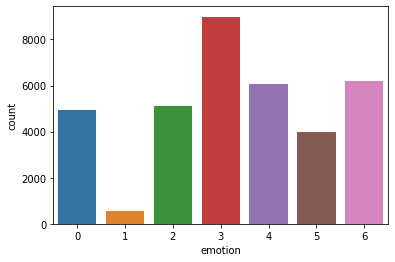

In [15]:
#Bu veriler grafikleştirildi
sns.countplot(df.emotion)
pyplot.show()

In [16]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

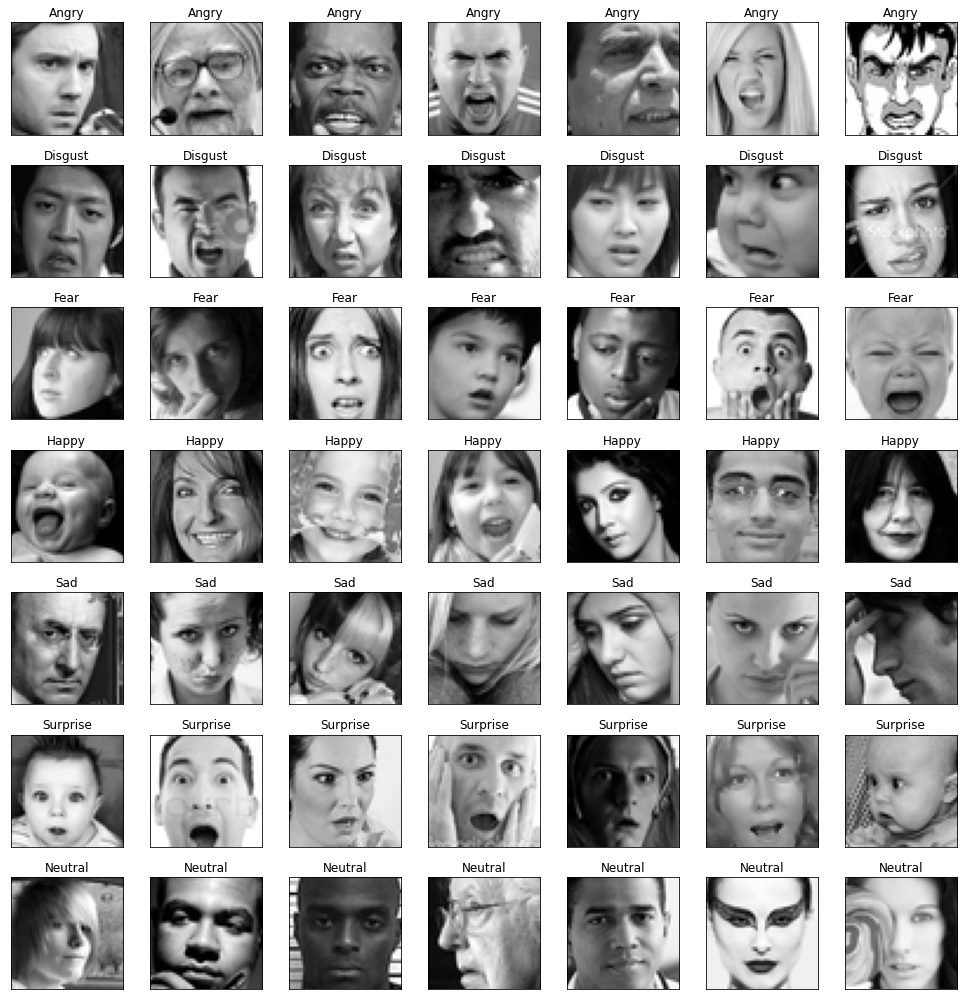

In [17]:
#Örnek veriler ekrana bastırıldı
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [18]:
#Kullanılacak sınıflar belirlendi
INTERESTED_LABELS = [0,1,2,3, 4,5, 6]

In [19]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(35887, 3)

In [20]:
#Veriler ve boyutları diziye atandı
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [21]:
img_array.shape

(35887, 48, 48, 1)

In [22]:
#Label Encoding yapıldı
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [23]:
#Dict oluşturuldu
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [24]:
#%10 Test verisi olmak üzere veriler bölündü.
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [25]:
del df
del img_array
del img_labels

In [26]:
#Veri boyutları belirlendi.
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [27]:
#Model eğitimi iyileştirilmesi için veriler normalize edildi.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [28]:
#CNN oluşturuldu, ayrıntılar dökümantasyonda mevcut.
def build_net(optim):
    
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    


    return net

In [29]:

#Overfitting'i engellemek için Early Stopping oluşturuldu.
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

#Val acc belirli bir tekrardan sonra (patience) değişmediğinde learning rate'in artırılması için Learning Rate Scheduler oluşturuldu.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [30]:
# Image Data Generator ile datagen oluşturuldu.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [32]:
#Çeşitli denemelerden sonra batch size'ın 32 olmasına karar verildi. Nadam ve Adam olmak üzere 2 optimizer oluşturuldu.
#Nadam'ın daha başarılı sonuçlar elde ettiği görüldü.
batch_size = 32 
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon= 1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100
1009/1009 [==============================] - 57s 25ms/step - loss: 2.0614 - accuracy: 0.2392 - val_loss: 1.6655 - val_accuracy: 0.3525
Epoch 2/100
1009/1009 [==============================] - 24s 24ms/step - loss: 1.6413 - accuracy: 0.3507 - val_loss: 1.4647 - val_accuracy: 0.4341
Epoch 3/100
1009/1009 [==============================] - 24s 24ms/step - loss: 1.4714 - accuracy: 0.4307 - val_loss: 1.2824 - val_accuracy: 0.5130
Epoch 4/100
1009/1009 [==============================] - 24s 24ms/step - loss: 1.3788 - accuracy: 0.4741 - val_loss: 1.2408 - val_accuracy: 0.5241
Epoch 5/100
1009/1009 [==============================] - 24s 24ms/step - loss: 1.3220 - accuracy: 0.4982 - val_loss: 1.1345 - val_accuracy: 0.5676
Epoch 6/100
1009/1009 [==============================] - 24s 24ms/step - loss: 1.2743 - accuracy: 0.5200 - val_loss: 1.1042 - val_accuracy: 0.5807
Epoch 7/100
1009/1009 [==============================] - 24s 24ms/step - loss: 1.2438 - accuracy: 0.5326 - val_loss: 1

In [33]:
#Model kaydedildi
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")